# Notebook 03: Time Series Forecasting - Quarterly

This notebook forecasts Q2, Q3, and Q4 sales for watches using the data cleaned in [Notebook 1: Data Cleaning](01_data_cleaning.ipynb).

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.var import VAR

from sklearn.metrics import mean_squared_error

import random

# custom function imports
from custom_functions import *
from forecasting_custom_functions import *

In [2]:
df_models = pd.read_csv('../data/cleaned_datasets/df_models.csv')

# Keep only items in the proposal that have previous sales
df_models.dropna(subset='proposal_priority',inplace=True)

time_now = datetime.datetime.now()
df_models.dropna(subset=time_now.strftime(f"%Y-%m"),inplace=True)

# Transform so that datetime is the index, and style_id is the colum
y = return_sales(df_models,'style_id')

# Resample so now quarterly
y = y.resample('Q',kind='period').sum()

# Reduce size of y to previous quarter
previous_quarter_time = time_now - pd.Timedelta(365/4, unit='d')
previous_quarter = previous_quarter_time.strftime(f"%Y%Q{(previous_quarter_time.month - 1 ) // 3 + 1}")

y = y.loc[:previous_quarter,:]

# Sort values by 2022Q1 sales
y.sort_values(axis='columns',by = ['2022Q1'], ascending=False, inplace=True)

In [3]:
df_models = pd.read_csv('../data/cleaned_datasets/df_models.csv')

# Keep only items in the proposal that have previous sales
df_models.dropna(subset='proposal_priority',inplace=True)

time_now = datetime.datetime.now()
df_models.dropna(subset=time_now.strftime(f"%Y-%m"),inplace=True)

# Transform so that datetime is the index, and style_id is the colum
y = return_sales(df_models,'style_id')

# Resample so now quarterly
y = y.resample('Q',kind='period').sum()

# Sort values by 2022Q1 sales
y.sort_values(axis='columns',by = ['2022Q1'], ascending=False, inplace=True)

# Reduce size of y to previous quarter
previous_quarter_time = time_now - pd.Timedelta(365/4, unit='d')
previous_quarter = previous_quarter_time.strftime(f"%Y%Q{(previous_quarter_time.month - 1 ) // 3 + 1}")

y = y.loc[:previous_quarter,:]

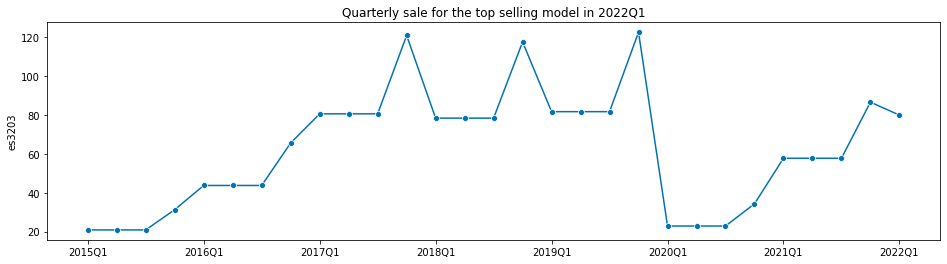

In [4]:
plot_series(y.iloc[:,0])
plt.title('Quarterly sale for the top selling model in 2022Q1');

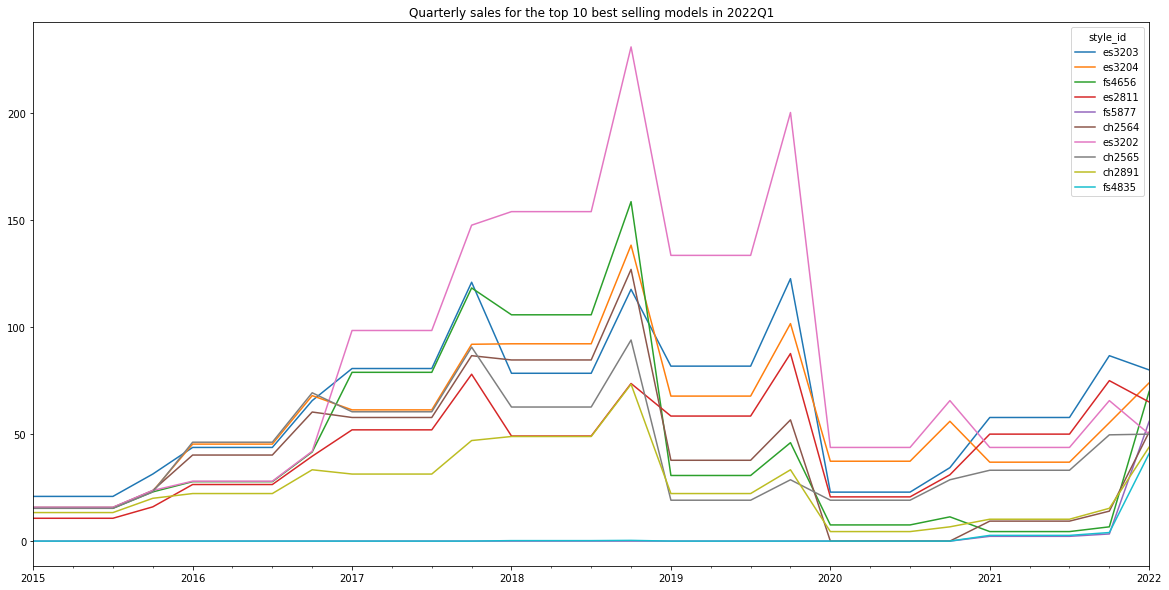

In [5]:
y.iloc[:,0:10].plot(figsize=(20,10),title='Quarterly sales for the top 10 best selling models in 2022Q1');

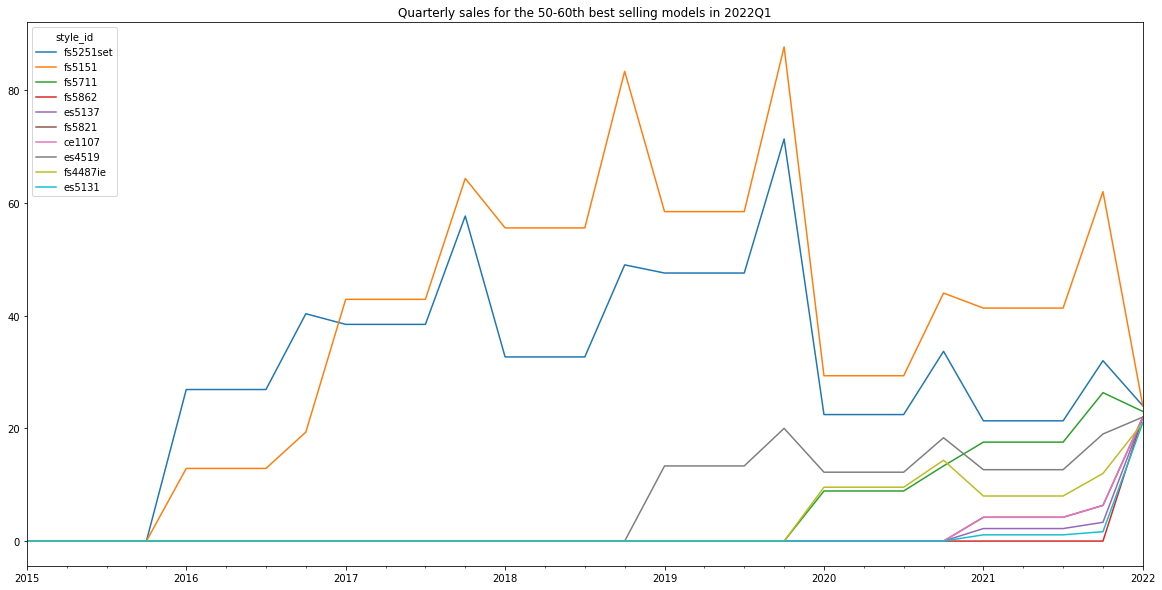

In [6]:
y.iloc[:,50:60].plot(figsize=(20,10),title='Quarterly sales for the 50-60th best selling models in 2022Q1');

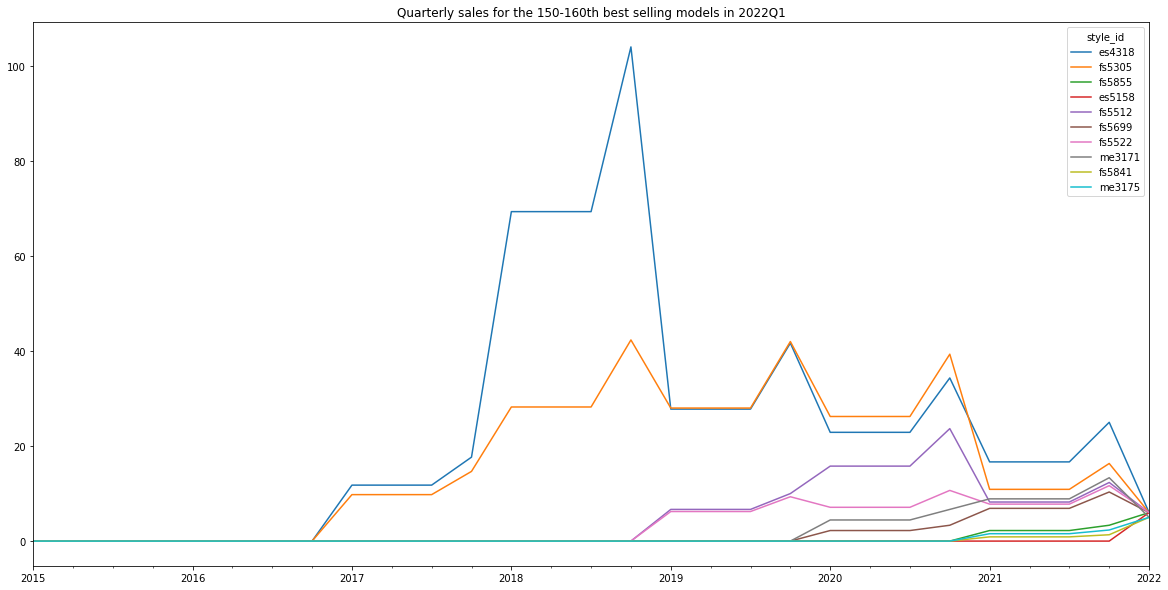

In [7]:
y.iloc[:,150:160].plot(figsize=(20,10),title='Quarterly sales for the 150-160th best selling models in 2022Q1');

#### Temporal TTS

In [8]:
y_train, y_test = temporal_train_test_split(y, test_size=1)

In [9]:
y_train.shape

(28, 265)

In [10]:
y_test.shape

(1, 265)

### Baseline model using last value

In [11]:
baseline_last = NaiveForecaster() # default strategy is last

In [12]:
baseline_last.fit(y_train)

NaiveForecaster()

In [13]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 28 entries, 2015Q1 to 2021Q4
Freq: Q-DEC
Columns: 265 entries, es3203 to me3220
dtypes: float64(265)
memory usage: 58.2 KB


In [14]:
pred_freq_list = [1,2,3,4]
baseline_last_preds = baseline_last.predict(pred_freq_list)

In [15]:
baseline_last_rmse = pred_rmse(y_test, baseline_last_preds)
baseline_last_rmse

12.9175420681243

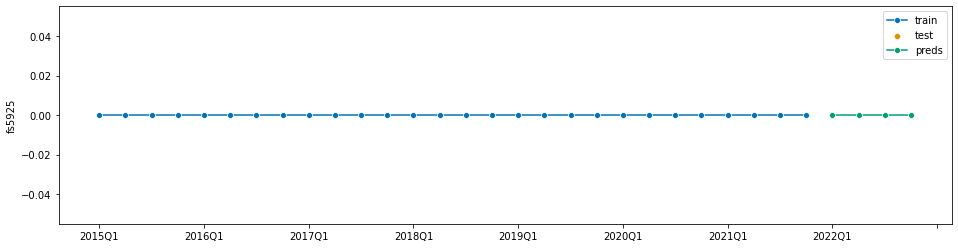

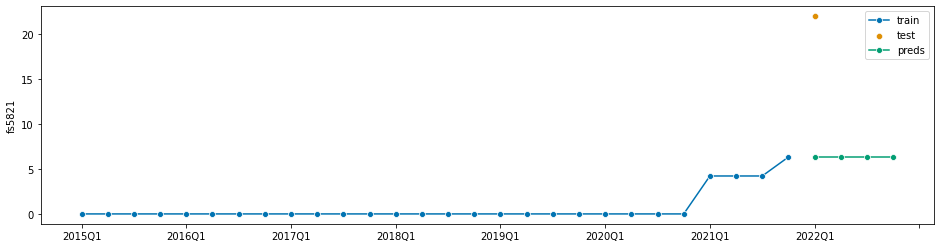

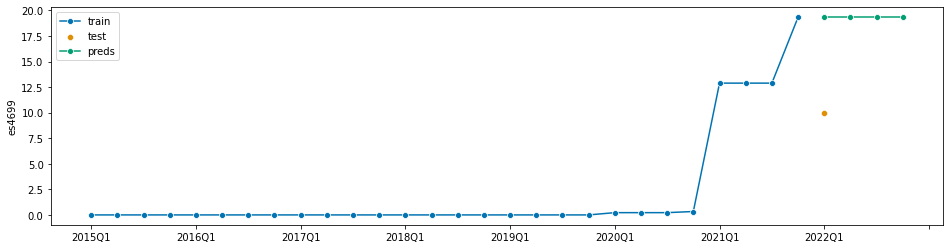

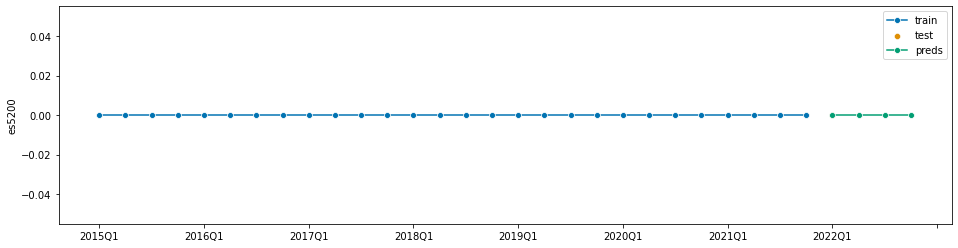

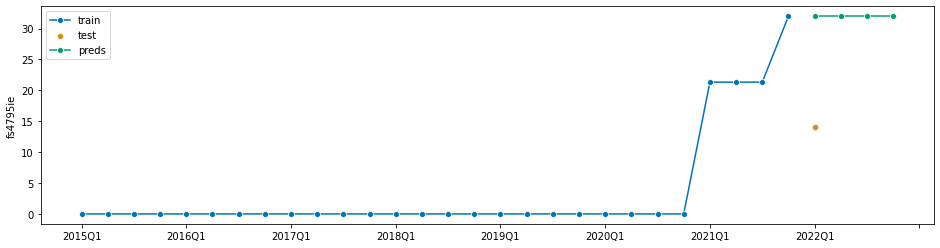

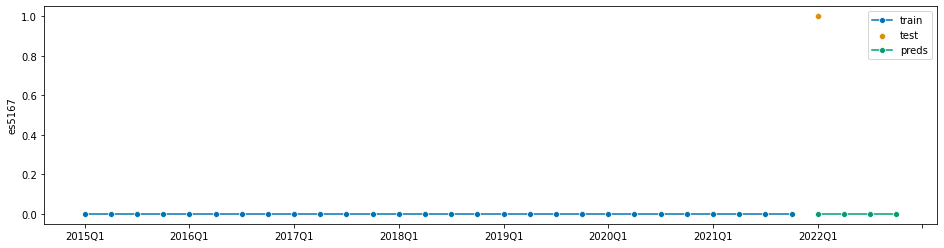

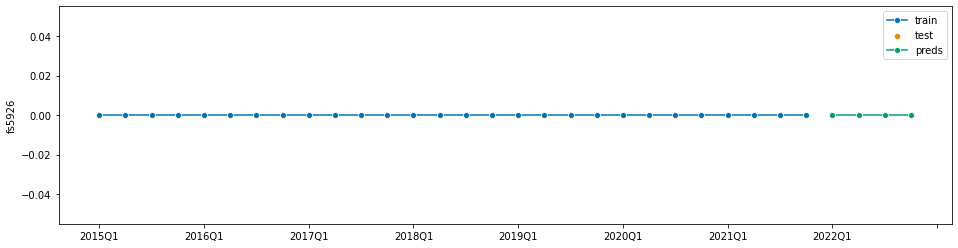

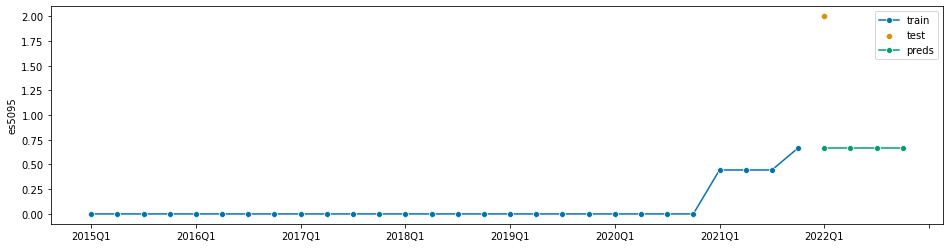

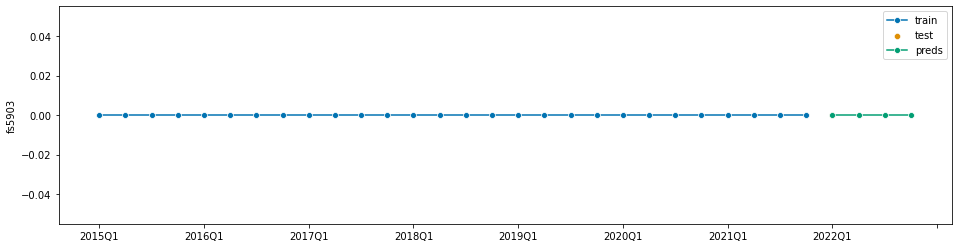

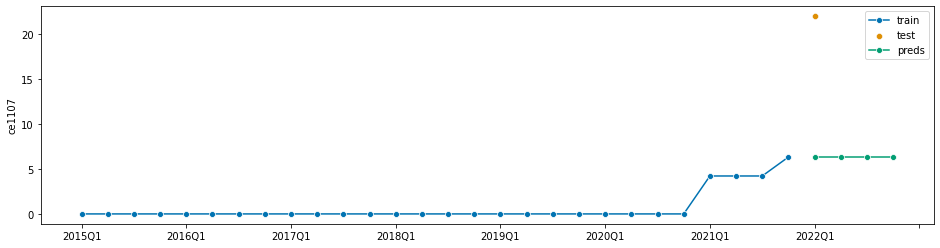

In [16]:
plot_pred(y_train, y_test, baseline_last_preds)

### Baseline model using drift

In [17]:
baseline_drift = NaiveForecaster(strategy='drift')
baseline_drift.fit(y_train)
baseline_drift_preds = baseline_drift.predict(pred_freq_list)
pred_rmse(y_test,baseline_drift_preds)

13.116478048531903

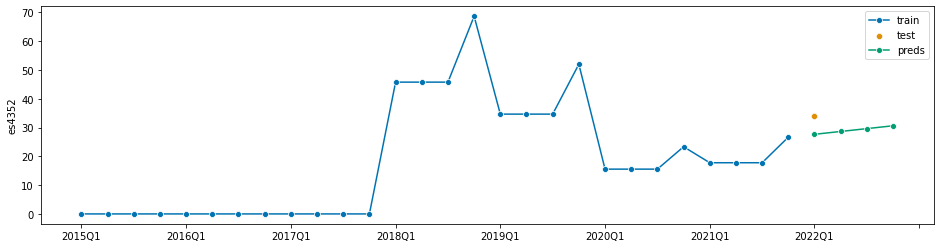

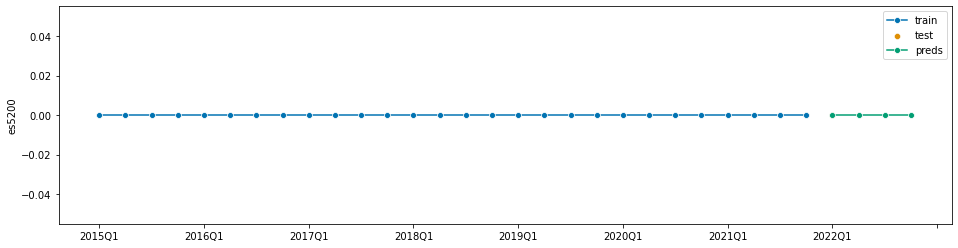

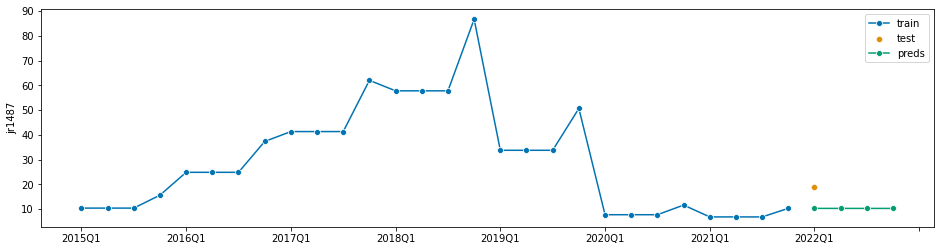

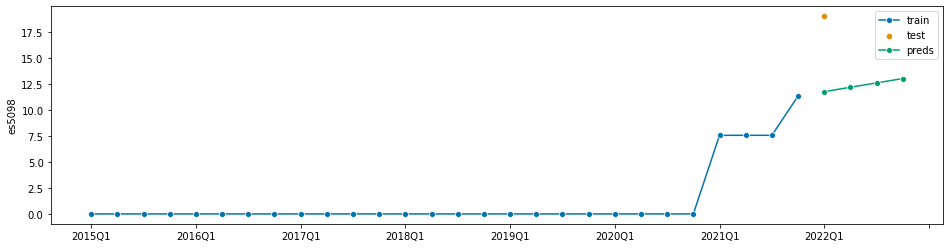

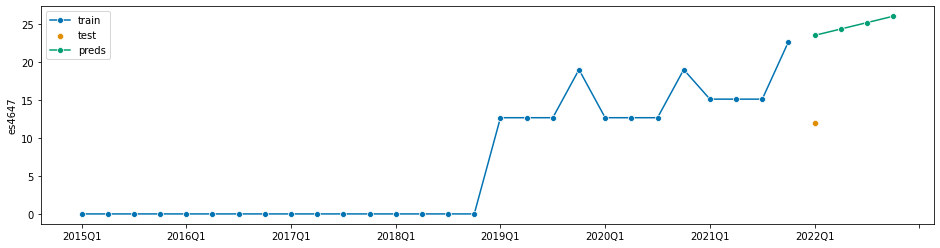

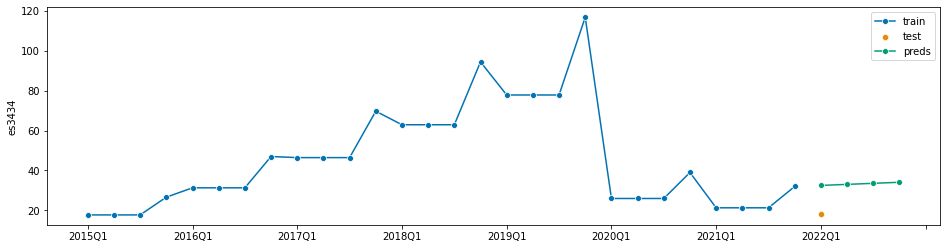

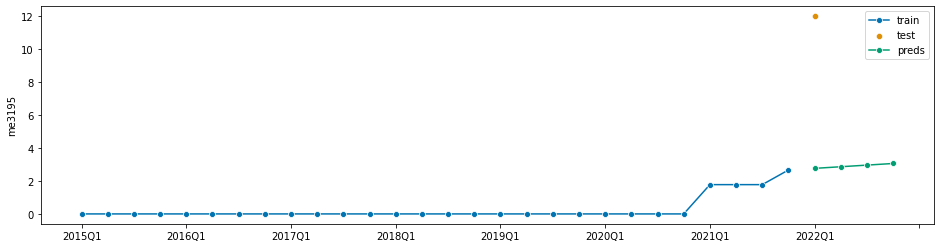

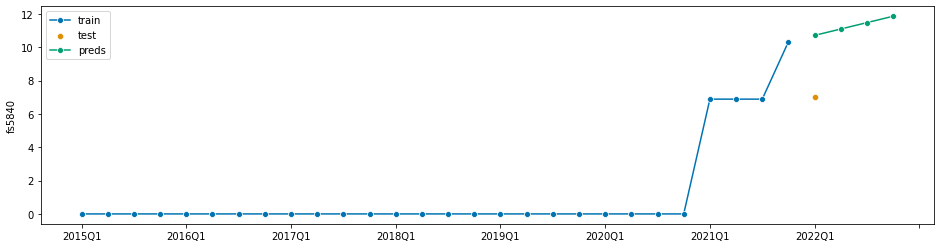

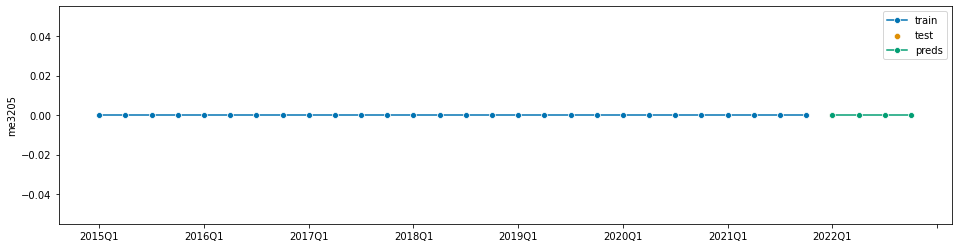

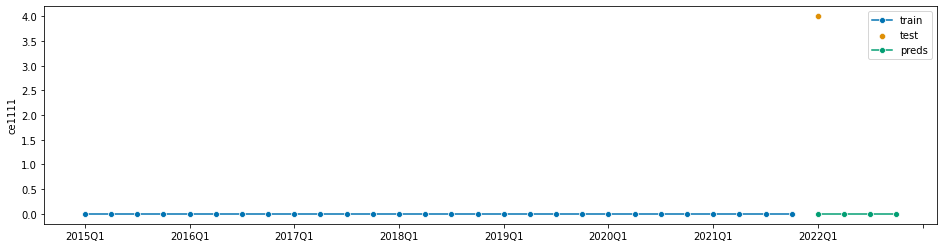

In [18]:
plot_pred(y_train,y_test,baseline_drift_preds)

### Baseline last seasonal cycle (quarterly)

In [19]:
baseline_seasonal = NaiveForecaster(strategy='last',sp=4)
baseline_seasonal.fit(y_train)
baseline_seasonal_preds = baseline_seasonal.predict(pred_freq_list)
pred_rmse(y_test, baseline_seasonal_preds)

12.758056059192713

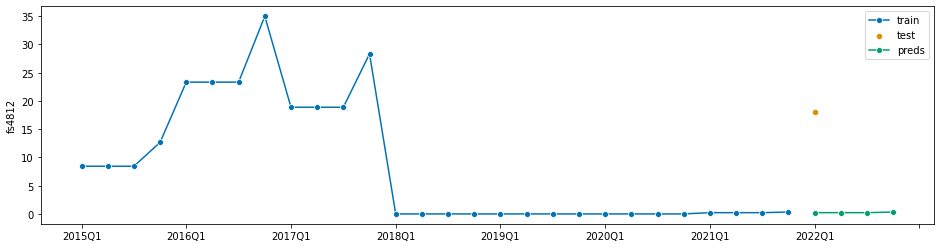

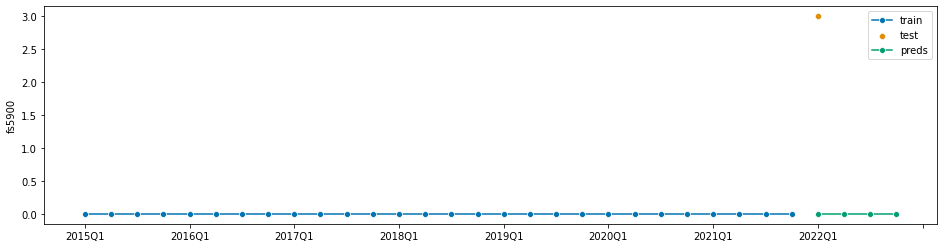

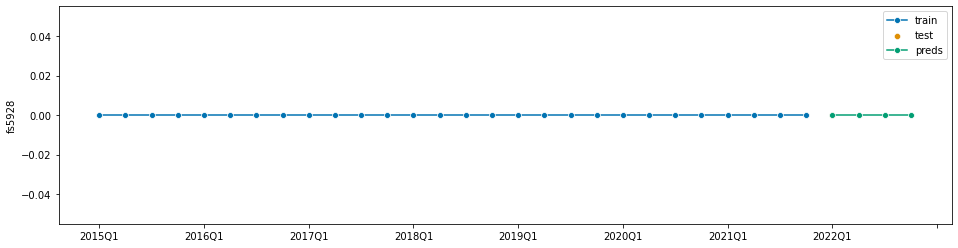

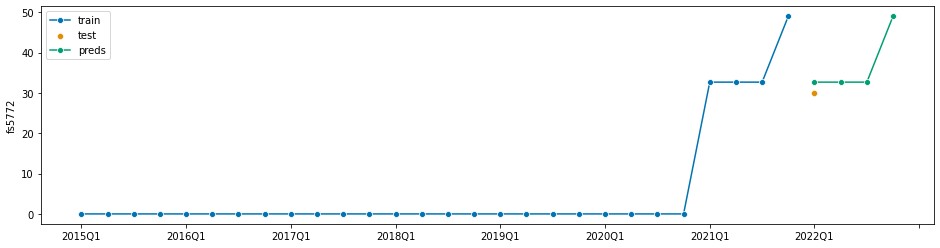

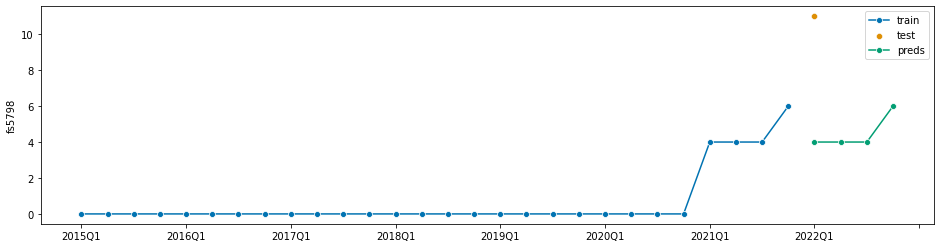

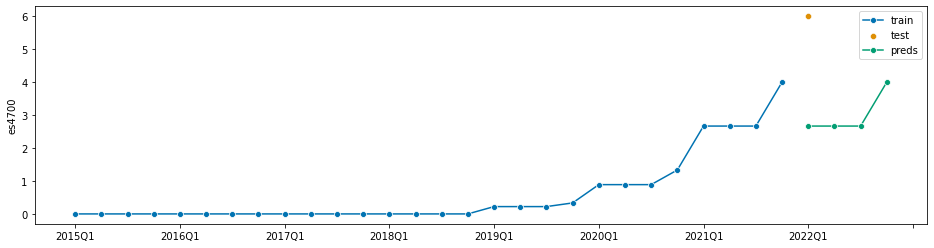

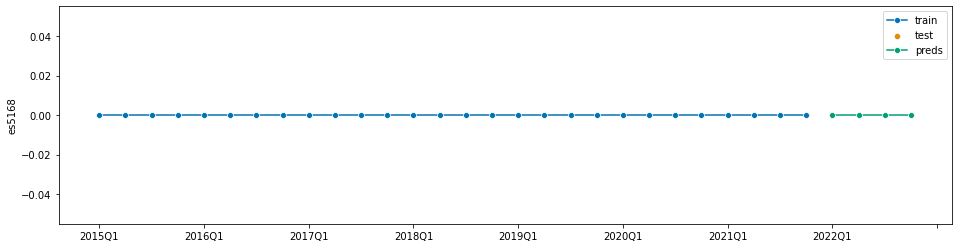

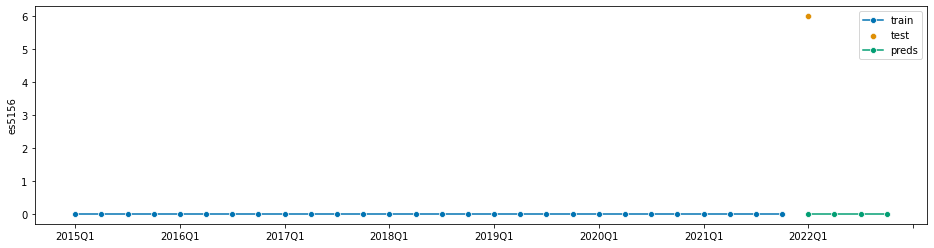

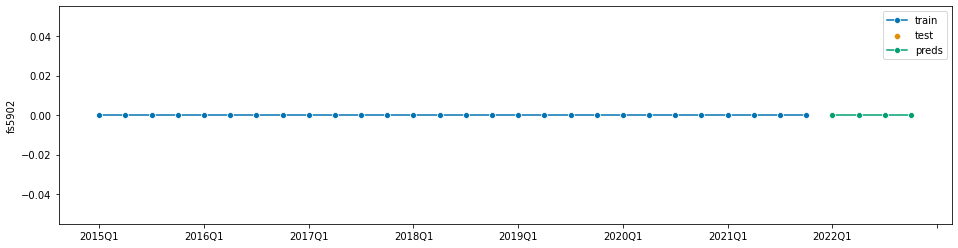

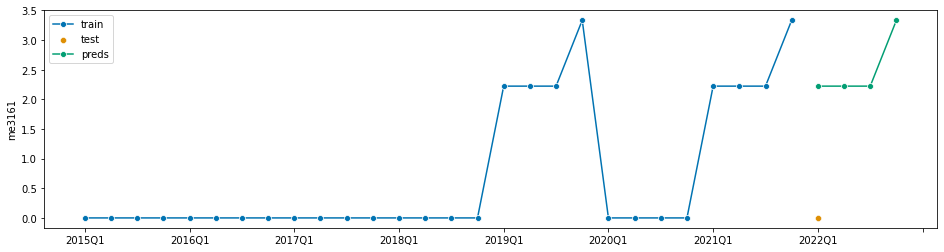

In [20]:
plot_pred(y_train, y_test, baseline_seasonal_preds)

### SARIMA

In [21]:
# # Used this to generate SARIMA predictions
# sarima_preds = pd.DataFrame()
# for model in y_train:
#     sarima_model = AutoARIMA(sp=4, trace=True)
#     print(model)
#     sarima_model.fit(y_train[model])
#     try:
#         sarima_preds[model] = sarima_model.predict(1)
#     except:
#         sarima_preds[model] = np.nan
# sarima_preds.T.to_csv('../data/predictions/sarima_preds.csv')

In [22]:
sarima_preds = pd.read_csv('../data/predictions/sarima_preds.csv', index_col='Unnamed: 0')

In [23]:
sarima_preds = sarima_preds.T

In [24]:
sarima_preds.index = pd.PeriodIndex(sarima_preds.index,freq='Q-DEC',) 

In [25]:
sarima_preds.T.isna().sum() # Only failed on 6, not too bad

2022Q1    6
Freq: Q-DEC, dtype: int64

In [26]:
sarima_preds.columns = sarima_preds.columns.str.lower()

In [27]:
# Find those models which failed
model_failure_SARIMA = []
for model,failed in sarima_preds.isna().items():
    if failed[0]:
        model_failure_SARIMA.append(model)
model_failure_SARIMA

['fs5877', 'es5137', 'fs5799', 'fs5855', 'fs5663', 'es5097']

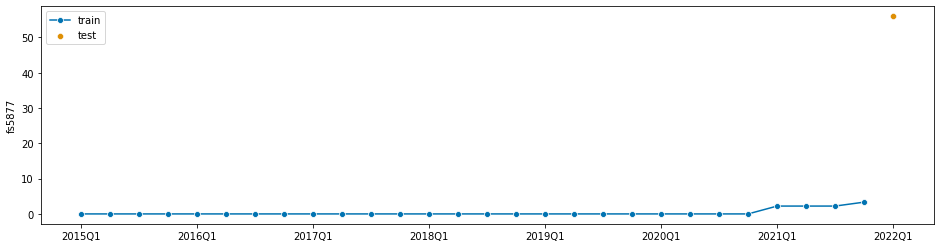

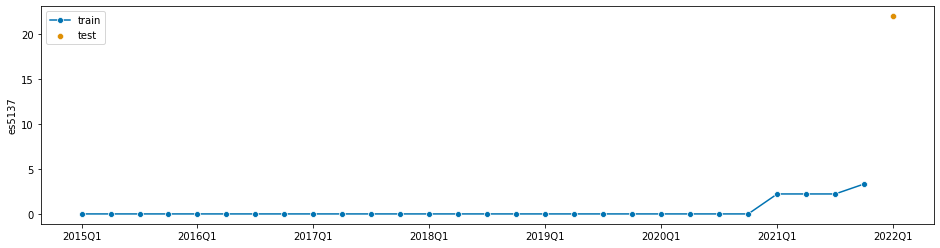

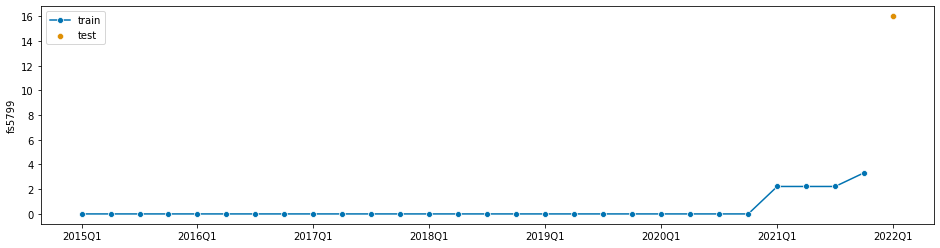

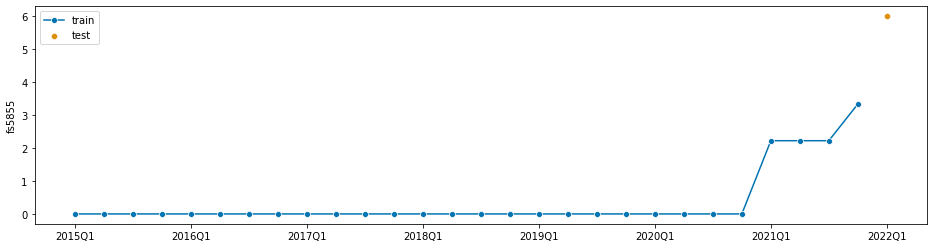

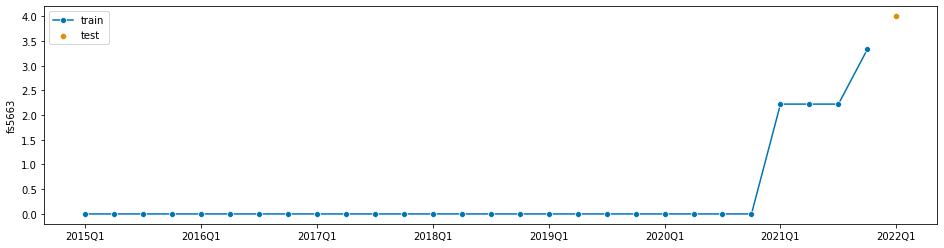

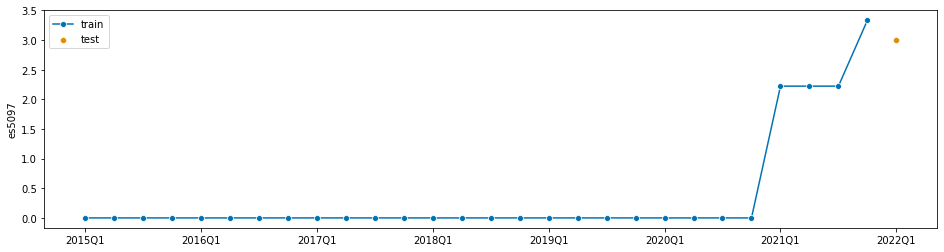

In [28]:
for i in model_failure_SARIMA:
    plot_series(y_train.loc[:,i], y_test.loc[:,i], labels = ['train','test']);

In [29]:
sarima_preds = sarima_preds.drop(columns=model_failure_SARIMA)

In [30]:
sarima_y_test = y_test.drop(columns=model_failure_SARIMA)

In [31]:
sarima_y_test

style_id,es3203,es3204,fs4656,es2811,ch2564,es3202,ch2565,ch2891,fs4835,es5130,...,fs5916,fs5915,fs5914,fs5907,fs5903,fs5902,fs5901,fs5898,es5165,me3220
2022Q1,80.0,74.0,70.0,65.0,51.0,50.0,50.0,44.0,41.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
pred_rmse(sarima_y_test, sarima_preds)

14.53489621400233

In [33]:
sarima_y_train = y_train.drop(columns=model_failure_SARIMA)

In [34]:
sarima_y_train.shape, sarima_y_test.shape, sarima_preds.shape

((28, 259), (1, 259), (1, 259))

In [35]:
sarima_y_test

style_id,es3203,es3204,fs4656,es2811,ch2564,es3202,ch2565,ch2891,fs4835,es5130,...,fs5916,fs5915,fs5914,fs5907,fs5903,fs5902,fs5901,fs5898,es5165,me3220
2022Q1,80.0,74.0,70.0,65.0,51.0,50.0,50.0,44.0,41.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
sarima_preds.index

PeriodIndex(['2022Q1'], dtype='period[Q-DEC]')

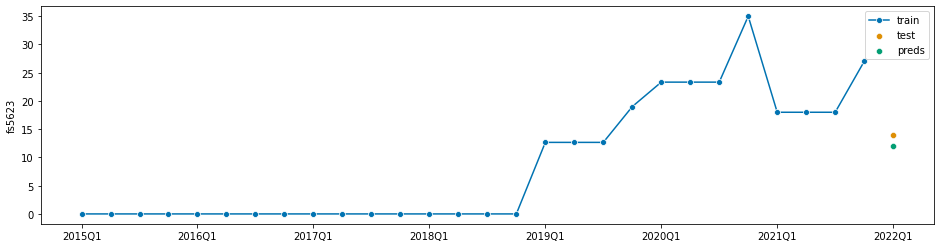

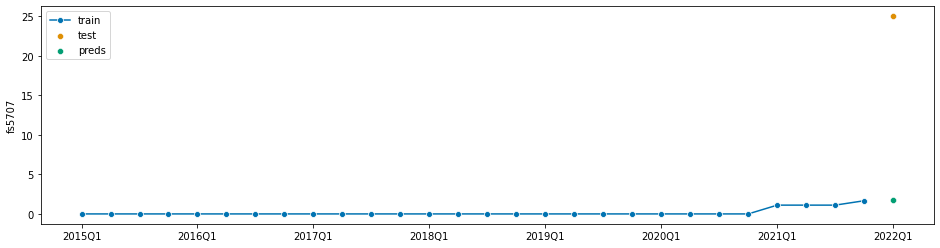

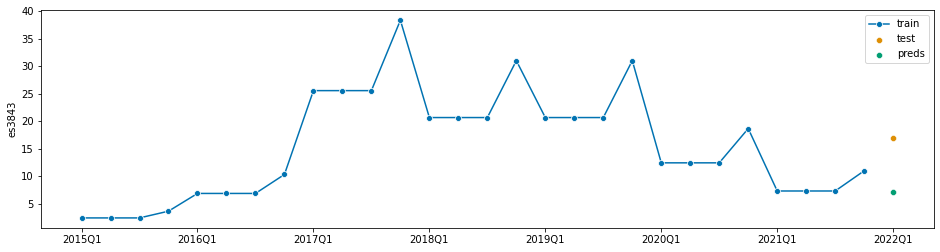

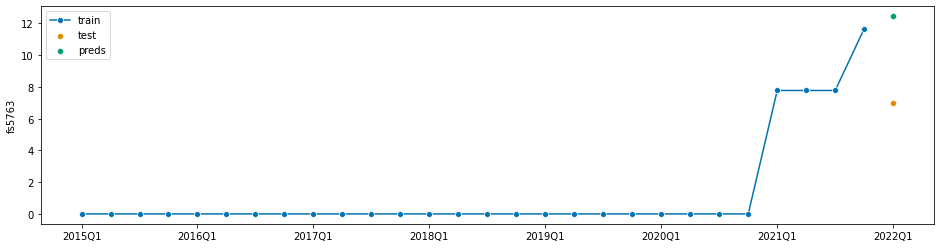

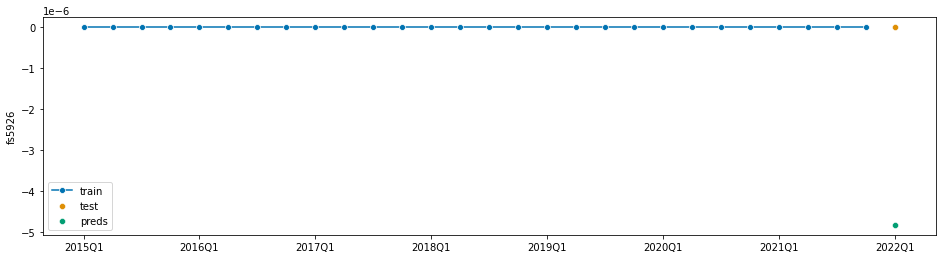

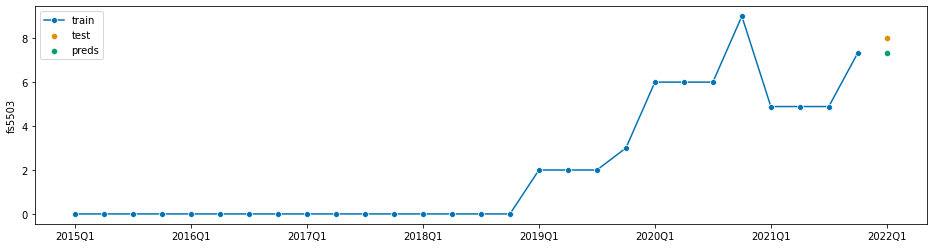

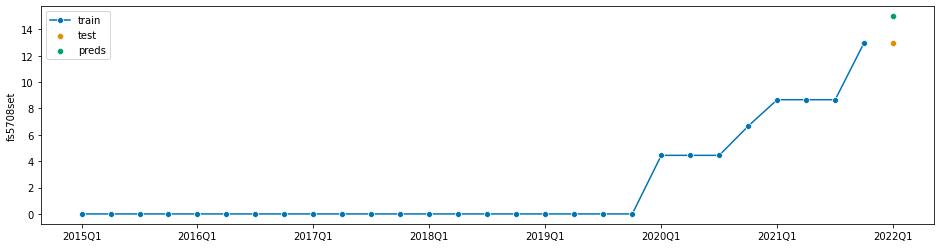

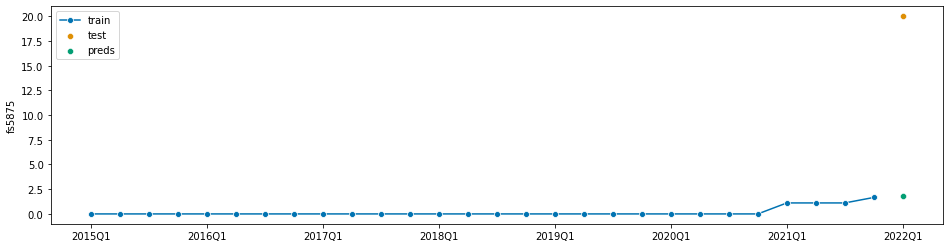

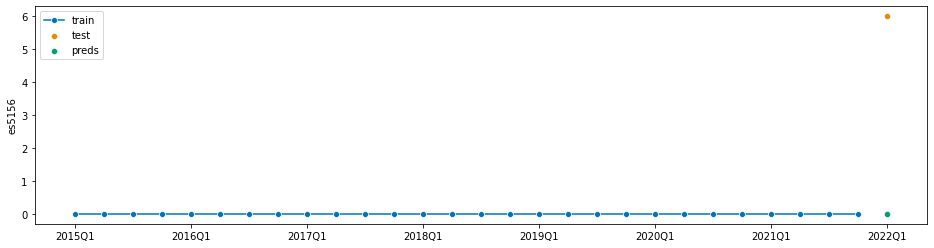

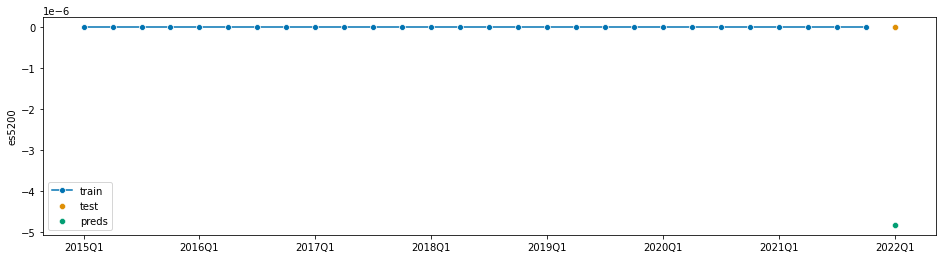

In [37]:
plot_pred(sarima_y_train, sarima_y_test, sarima_preds)